In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%time datos = pd.read_csv('data_tokens.csv')

Wall time: 15 ms


In [3]:
%time datos.tokens=datos.tokens.apply(literal_eval)

Wall time: 222 ms


In [4]:
datos.shape

(2856, 3)

In [5]:
conteo_categorias=datos['categorias'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
Bswift,1075,37.640056,37.640056
OM (organizationa mgmt),514,17.997199,55.637255
Leaves,305,10.679272,66.316527
Year-End,197,6.897759,73.214286
Time,185,6.477591,79.691877
Systems NA,180,6.302521,85.994398
HR Request,147,5.147059,91.141457
Interface Input,116,4.061625,95.203081
External Request,71,2.485994,97.689076
Employee Request,27,0.945378,98.634454


In [6]:
busqueda=tabla_categorias.query("acumulado<67").index
busqueda

Index(['Bswift', 'OM (organizationa mgmt)', 'Leaves'], dtype='object')

In [7]:
%time fdist = nltk.FreqDist(np.concatenate(datos.reset_index(drop=True)['tokens']))
%time tokens=fdist.most_common(len(fdist))
%time tokens_tf=pd.DataFrame(tokens,columns=['token','TF'])

Wall time: 139 ms
Wall time: 1.99 ms
Wall time: 2 ms


In [8]:
tokens_tf.query("TF>1",inplace=True)
tokens_tf.shape

(2543, 2)

In [9]:
datos.etiquetas.value_counts()

1    1075
2     514
0     400
3     305
4     197
5     185
6     180
Name: etiquetas, dtype: int64

In [10]:
query="TF<=1075 and TF>=18"
tokens_tf.query(query)

,token,TF
8,stop,1018
9,unsubscrib,973
10,verifi,961
11,inform,960
12,request,900
...,...,...
711,webmanag,18
712,theworknumb,18
713,ppay,18
714,tci,18


<AxesSubplot:ylabel='Frequency'>

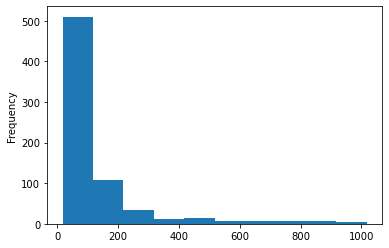

In [11]:
tokens_tf.query(query).TF.plot.hist()

In [12]:
bow = tokens_tf.query(query).token.values
bow.shape

(708,)

In [17]:
%time tfidf=pd.DataFrame(TfidfVectorizer(vocabulary=bow).fit_transform(datos['tokens'].str.join(" ")).toarray(), columns=bow)

Wall time: 94.7 ms


In [18]:
def obtener_similares(distancias):
    similares=set()
    for i in range(distancias.shape[0]):
        if i not in similares:
            similares.update((distancias[i]==1).nonzero()[0][1:])
    return list(similares)

In [19]:
busqueda=tabla_categorias.query("acumulado<67").index

In [20]:
%time distancias_coseno=cosine_similarity(tfidf,tfidf)
similares_coseno=pd.Series(datos.index).loc[obtener_similares(distancias_coseno)].values

Wall time: 110 ms


In [21]:
similares_coseno_filtrados = []
for categoria in busqueda:
    similares_coseno_filtrados.extend(datos.loc[similares_coseno].query("categorias==@categoria").index)

In [22]:
%time distancias_kernel=linear_kernel(tfidf,tfidf)
similares_kernel=pd.Series(datos.index).loc[obtener_similares(distancias_kernel)].values

Wall time: 103 ms


In [23]:
similares_kernel_filtrados = []
for categoria in busqueda:
    similares_kernel_filtrados.extend(datos.loc[similares_kernel].query("categorias==@categoria").index)

In [24]:
len(similares_coseno_filtrados),len(similares_kernel_filtrados)

(126, 99)

In [25]:
pd.DataFrame(similares_coseno_filtrados,columns=['similares']).to_csv('similares.csv',index=False)

In [26]:
datos

,categorias,tokens,etiquetas
0,Audit,"[address, move, address, yakima, minnesota, ol...",0
1,Audit,"[test, system]",0
2,Audit,"[test, system]",0
3,Audit,"[time, audit, request, afternoon, would, pleas...",0
4,Audit,"[time, audit, morn, would, provid, time, audit...",0
...,...,...,...
2851,Year-End,"[follow, name, termin, verifi, ssn, verifi, do...",4
2852,Year-End,"[inquiri, name, verifi, dob, yes, phone, numbe...",4
2853,Year-End,"[discrep, name, ssn, confirm, dob, confirm, ph...",4
2854,Year-End,"[inquiri, name, verifi, ssn, yes, phone, numbe...",4


In [27]:
datos.drop(index=similares_coseno_filtrados,inplace=True)

In [28]:
conteo_categorias=datos['categorias'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
Bswift,1053,38.571429,38.571429
OM (organizationa mgmt),422,15.457875,54.029304
Leaves,293,10.732601,64.761905
Year-End,197,7.216117,71.978022
Time,185,6.776557,78.754579
Systems NA,180,6.593407,85.347985
HR Request,147,5.384615,90.732601
Interface Input,116,4.249084,94.981685
External Request,71,2.600733,97.582418
Employee Request,27,0.989011,98.571429


In [29]:
conteo_categorias=datos['etiquetas'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
1,1053,38.571429,38.571429
2,422,15.457875,54.029304
0,400,14.652015,68.681319
3,293,10.732601,79.413919
4,197,7.216117,86.630037
5,185,6.776557,93.406593
6,180,6.593407,100.000000


In [35]:
pd.DataFrame(bow,columns=['token']).to_csv('bow.csv',index=False)

In [36]:
bow

array(['stop', 'unsubscrib', 'verifi', 'inform', 'request', 'thank',
       'address', 'lafargeholcim', 'benefit', 'com', 'mail', 'info',
       'www', 'need', 'ssn', 'employe', 'addit', 'resolut', 'research',
       'bswift', 'http', 'dob', 'want', 'posit', 'notifi', 'know',
       'insur', 'confirm', 'get', 'attach', 'confidenti', 'use', 'manag',
       'check', 'aggreg', 'contact', 'intend', 'messag', 'fax', 'report',
       'chang', 'provid', 'work', 'sap', 'copi', 'coverag', 'delet',
       'time', 'cell', 'immedi', 'date', 'document', 'call', 'updat',
       'offic', 'imag', 'recipi', 'could', 'life', 'cigna', 'std', 'sent',
       'hour', 'industri', 'escal', 'payment', 'hello', 'lafarg', 'yes',
       'card', 'let', 'creat', 'prohibit', 'account', 'direct',
       'question', 'addresse', 'back', 'follow', 'death', 'pension',
       'googl', 'compani', 'payrol', 'state', 'member', 'holcim', 'hsa',
       'would', 'requir', 'ask', 'wife', 'sourc', 'write', 'part',
       'system'